#PROYECTO PARCIAL: Clasificación de Fallas eléctricas

Entrega 3

Materia: Aprendizaje Automático

Profesor: Caballero, Nicolas

Alumno: Espindola, Matias

In [1]:
# Librerias

# Manipulación y análisis de datos
import pandas as pd
import numpy as np

# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento y modelado (scikit-learn)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

# Modelos de clasificación
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import time

# Métricas de evaluación
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score

# Configuración de visualización
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})

print ('Librerias fundamentales cargadas exitosamente')

Librerias fundamentales cargadas exitosamente


In [2]:
# Carga del dataset escalado
df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks_2AÑO1CUATRI/Aprendizaje Automatico/Parcial/archivos_dataset/faultdata-escalado.csv',
                 sep=',')
df.head()

,R,i25a,i25b,i25c,ira,irb,irc,isa,isb,isc,v25a,v25b,v25c,pg,qg,pr,qr,ps,CLASE_FALLA
0,-1.035292,-0.346,-0.424152,-0.349536,-0.257967,-0.316597,-0.289789,0.213231,-0.190946,-0.346298,-0.288895,-0.342542,-0.549078,-0.373422,-0.358251,-0.023656,-0.15381,-0.127586,1
1,-1.035262,-0.346,-0.424152,-0.349536,-0.257967,-0.316597,-0.289789,0.213231,-0.190946,-0.346298,-0.288895,-0.342542,-0.549078,-0.373422,-0.358251,-0.023656,-0.15381,-0.127586,1
2,-1.035201,-0.346,-0.424152,-0.349536,-0.257967,-0.316597,-0.289789,0.213231,-0.190946,-0.346298,-0.288895,-0.342542,-0.549078,-0.373422,-0.358251,-0.023656,-0.15381,-0.127586,1
3,-1.035141,-0.346,-0.424152,-0.349536,-0.257967,-0.316597,-0.289789,0.213231,-0.190946,-0.346298,-0.288895,-0.342542,-0.549078,-0.373422,-0.358251,-0.023656,-0.15381,-0.127586,1
4,-1.035081,-0.346,-0.424152,-0.349536,-0.257967,-0.316597,-0.289789,0.213231,-0.190946,-0.346298,-0.288895,-0.342542,-0.549078,-0.373422,-0.358251,-0.023656,-0.15381,-0.127586,1


### División en  X/Y

In [3]:
# Separa las variables predictoras de la variable objetivo
X = df.drop('CLASE_FALLA', axis=1)
y = df['CLASE_FALLA']

In [4]:
# Train (80) Test(20)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2, # tamaño de la prueba
    random_state=42,
    stratify=y # para mantener la proporcion de clases en los conjuntos de entrenamiento y prueba
    )

# Print de confirmación
print('División en conjuntos de entrenamiento (train) y prueba (test) realizada.')
print(f'Tamaño de Entrenamiento (train): {X_train.shape}')
print(f'Tamaño de Prueba (test): {X_test.shape}')

División en conjuntos de entrenamiento (train) y prueba (test) realizada.
Tamaño de Entrenamiento (train): (1430, 18)
Tamaño de Prueba (test): (358, 18)


# PCA
La aplicación de PCA (Principal Component Analysis) se decide en esta fase por dos razones fundamentales identificadas durante la Exploración de Datos (EDA):

1. Mitigación de la Multicolinealidad

El análisis de correlación confirmó la alta multicolinealidad entre las mediciones de las distintas fases (ej., i25a, i25b, i25c). PCA transforma estas variables correlacionadas en un nuevo conjunto de Componentes Principales no correlacionados. Esto estabiliza el análisis y permite un modelado más robusto.

2. Reducción de Ruido y Dimensionalidad

Con 18 variables predictoras, el modelo k-NN se vuelve sensible al fenómeno conocido como la "maldición de la dimensionalidad", donde la distancia pierde significado. Al establecer (n_components=0.95), el objetivo es reducir el número de variables a la cantidad mínima necesaria para retener el 95% de la varianza total de los datos. Esto simplificará el modelo, reducirá el ruido y mejorará la eficiencia y generalización de los clasificadores k-NN y Regresión Logística.

In [5]:
# Aplicación de PCA
pca = PCA(n_components=0.95).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"PCA aplicado. Componentes necesarios para el 95% de la varianza: {pca.n_components_}")
print(f"Forma de X_train original: {X_train.shape}")
print(f"Forma de X_train transformado (PCA): {X_train_pca.shape}")

PCA aplicado. Componentes necesarios para el 95% de la varianza: 9
Forma de X_train original: (1430, 18)
Forma de X_train transformado (PCA): (1430, 9)


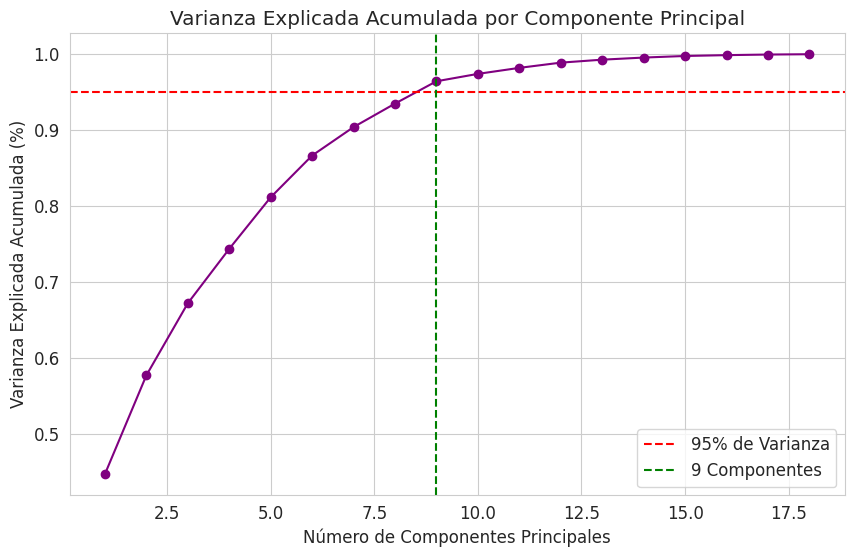


Se requieren 9 Componentes Principales para explicar el 95% de la varianza total.


In [6]:
# Visualizaciónes del PCA

# Ejecutar PCA sin restricción (n_components=None) para obtener todas las PCs
pca_full = PCA(n_components=None).fit(X_train)

# Obtener la varianza explicada por cada componente
varianza_explicada = pca_full.explained_variance_ratio_

# Calcular la varianza explicada acumulada
varianza_acumulada = np.cumsum(varianza_explicada)

# Identificar el número de componentes para el 95%
n_components_95 = np.where(varianza_acumulada >= 0.95)[0][0] + 1

# Graficar la Varianza Acumulada
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(varianza_acumulada) + 1), varianza_acumulada, marker='o', linestyle='-', color='purple')
plt.title('Varianza Explicada Acumulada por Componente Principal')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada (%)')
plt.grid(True)

# Marcar el umbral del 95%
plt.axhline(y=0.95, color='r', linestyle='--', label='95% de Varianza')
plt.axvline(x=n_components_95, color='g', linestyle='--', label=f'{n_components_95} Componentes')
plt.legend()
plt.show()

print(f"\nSe requieren {n_components_95} Componentes Principales para explicar el 95% de la varianza total.")

### Conclusión del Análisis de Varianza Explicada

El gráfico de Varianza Explicada Acumulada demuestra que se puede lograr una reducción de dimensionalidad significativa manteniendo la mayor parte de la información.

* Variables originales: 18
* Varianza Retenida: 95%
* Componentes Principales (PCs) Necesarios: **9**

Esto significa que el problema de clasificación se simplificará al usar solo 9 variables transformadas en lugar de las 18 originales, mitigando la multicolinealidad y la "maldición de la dimensionalidad" para el k-NN.

# Prueba y Selección de modelos

In [7]:
# Rango de valores de k a probar (1 a 10)
k_values = np.arange(1, 10)
mejor_k = 0
mejor_accuracy = 0
reporte_knn = ""

print("--- Exploración del Hiperparámetro k en k-NN ---\n")

for k in k_values:
    # Crear el modelo k-NN
    modelo_knn = KNeighborsClassifier(n_neighbors=k)

    # Entrenar el modelo con los datos PCA de entrenamiento
    modelo_knn.fit(X_train_pca, y_train)

    # Predecir en el conjunto de prueba (X_test_pca)
    y_pred = modelo_knn.predict(X_test_pca)

    # Calcular el Accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Imprimir el resultado
    print(f"k = {k:2d} | Accuracy: {accuracy:.4f}")

    # Registrar el mejor k encontrado
    if accuracy > mejor_accuracy:
        mejor_accuracy = accuracy
        mejor_k = k
        # Reporte de clasificación
        reporte_knn = classification_report(y_test, y_pred, zero_division=0)

print("\n-------------------------------------------------------------")
print(f" Mejor k encontrado en esta exploración: k = {mejor_k:2d} (Accuracy: {mejor_accuracy:.4f})")
print("\n--- Reporte de Clasificación del Modelo Óptimo ---")
print(reporte_knn)

accuracy_knn = mejor_accuracy

--- Exploración del Hiperparámetro k en k-NN ---

k =  1 | Accuracy: 0.3827
k =  2 | Accuracy: 0.4078
k =  3 | Accuracy: 0.4078
k =  4 | Accuracy: 0.4106
k =  5 | Accuracy: 0.4078
k =  6 | Accuracy: 0.4274
k =  7 | Accuracy: 0.4050
k =  8 | Accuracy: 0.4134
k =  9 | Accuracy: 0.4022

-------------------------------------------------------------
 Mejor k encontrado en esta exploración: k =  6 (Accuracy: 0.4274)

--- Reporte de Clasificación del Modelo Óptimo ---
              precision    recall  f1-score   support

           1       0.20      0.47      0.28        30
           2       0.84      0.90      0.87        30
           3       0.30      0.67      0.42        30
           4       0.57      0.40      0.47        30
           5       0.19      0.10      0.13        30
           6       0.36      0.43      0.39        30
           7       0.55      0.57      0.56        30
           8       0.41      0.30      0.35        30
           9       0.22      0.07      0.10    

In [8]:
# Rango de valores de C a probar
C_values = [0.01, 0.1, 1, 10, 100]
mejor_C = 0
mejor_accuracy_c = 0
mejor_reporte_reglog = ""

print("--- Exploración del Hiperparámetro C en Regresión Logística ---\n")

for C in C_values:
    # Crear el modelo de Regresión Logística
    reg_log = LogisticRegression(
        solver='saga',
        penalty='l2', # Usamos L2, que fue el mejor encontrado
        C=C, # Iteramos sobre el valor de C
        max_iter=5000,
        random_state=42
    )

    # Entrenar el modelo con los datos PCA de entrenamiento
    reg_log.fit(X_train_pca, y_train)

    # Predecir en el conjunto de prueba (X_test_pca)
    y_pred = reg_log.predict(X_test_pca)

    # Calcular el Accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Imprimir el resultado
    print(f"C = {C:<6} | Accuracy: {accuracy:.4f}")

    # Registrar el mejor C encontrado
    if accuracy > mejor_accuracy_c:
        mejor_accuracy_c = accuracy
        mejor_C = C
        # Reporte de clasificación
        reporte_reglog = classification_report(y_test, y_pred, zero_division=0)

print("\n-------------------------------------------------------------")
print(f" Mejor C encontrado en esta exploración: C = {mejor_C:<6} (Accuracy: {mejor_accuracy_c:.4f})")
print("\n--- Reporte de Clasificación del Modelo Óptimo ---")
print(reporte_reglog)

accuracy_reglog = mejor_accuracy_c

--- Exploración del Hiperparámetro C en Regresión Logística ---

C = 0.01   | Accuracy: 0.3128
C = 0.1    | Accuracy: 0.3911
C = 1      | Accuracy: 0.4162
C = 10     | Accuracy: 0.4721
C = 100    | Accuracy: 0.4888

-------------------------------------------------------------
 Mejor C encontrado en esta exploración: C = 100    (Accuracy: 0.4888)

--- Reporte de Clasificación del Modelo Óptimo ---
              precision    recall  f1-score   support

           1       0.29      0.73      0.42        30
           2       1.00      1.00      1.00        30
           3       0.34      0.67      0.45        30
           4       0.87      0.43      0.58        30
           5       0.73      0.27      0.39        30
           6       0.67      0.40      0.50        30
           7       0.47      0.77      0.58        30
           8       0.60      0.20      0.30        30
           9       0.33      0.07      0.11        30
          10       0.21      0.21      0.21        29
    

In [9]:
# Selección del modelo optimo segun su accuracy final
if accuracy_knn > accuracy_reglog:
    print("\nCONCLUSIÓN FINAL: k-NN (con PCA y optimizado) es el modelo con mejor rendimiento.")
    print(f"Accuracy Final (Optimizado): {accuracy_knn:.4f}")
elif accuracy_reglog > accuracy_knn:
    print("\nCONCLUSIÓN FINAL: La Regresión Logística (con PCA y optimizada) es el modelo con mejor rendimiento.")
    print(f"Accuracy Final (Optimizado): {accuracy_reglog:.4f}")
else:
    print("\nCONCLUSIÓN: Ambos modelos optimizados tienen rendimientos idénticos.")


CONCLUSIÓN FINAL: La Regresión Logística (con PCA y optimizada) es el modelo con mejor rendimiento.
Accuracy Final (Optimizado): 0.4888


# Regresión Logística: Despliegue y Análisis





--- REPORTE DE CLASIFICACIÓN (Métricas Detalladas) ---
              precision    recall  f1-score   support

           1       0.29      0.73      0.42        30
           2       1.00      1.00      1.00        30
           3       0.34      0.67      0.45        30
           4       0.87      0.43      0.58        30
           5       0.73      0.27      0.39        30
           6       0.67      0.40      0.50        30
           7       0.47      0.77      0.58        30
           8       0.60      0.20      0.30        30
           9       0.33      0.07      0.11        30
          10       0.21      0.21      0.21        29
          11       0.46      0.38      0.42        29
          12       0.67      0.73      0.70        30

    accuracy                           0.49       358
   macro avg       0.55      0.49      0.47       358
weighted avg       0.55      0.49      0.47       358



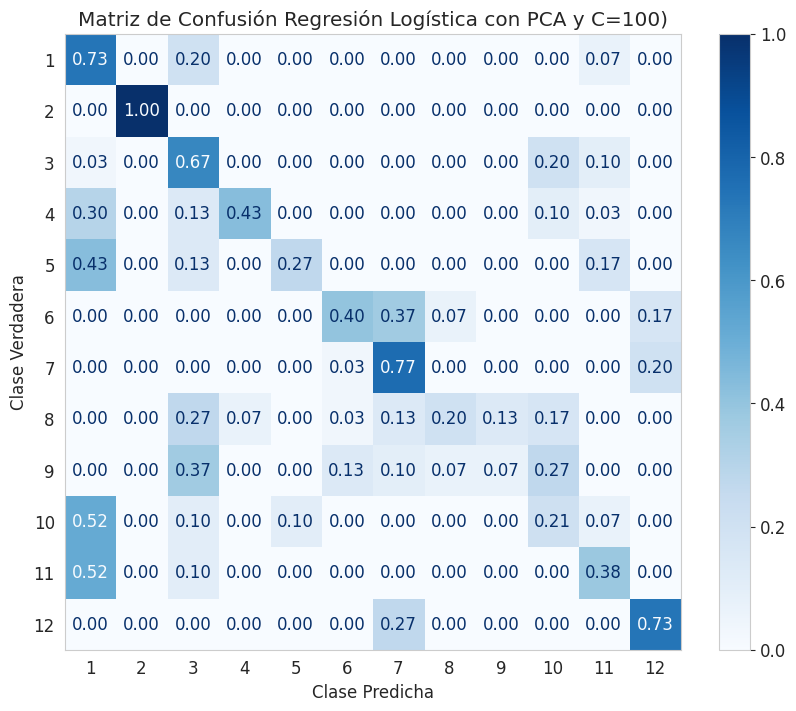


--- INTERPRETACIÓN VISUAL ---
Cada fila representa la CLASE VERDADERA. La diagonal principal (de arriba izquierda a abajo derecha) es el porcentaje de acierto ('Recall') por clase.
Un valor de 1.00 fuera de la diagonal (ej: Fila X, Columna Y) significa que TODAS las muestras de la Clase X fueron erróneamente clasificadas como Clase Y.


In [10]:
# Reporte de Clasificación y Matriz de Confusión

print("--- REPORTE DE CLASIFICACIÓN (Métricas Detalladas) ---")
# Generar el reporte de clasificación completo
# Usamos la variable y_test de tu notebook
print(classification_report(y_test, y_pred))

# Matriz de Confusión
# Las etiquetas de las clases son de 1 a 12
n_clases = np.unique(y_test)
conf_matrix = confusion_matrix(y_test, y_pred, labels=n_clases)

# Normalización de la matriz para ver proporciones
# cm.sum(axis=1) suma todos los elementos por fila (clase verdadera)
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(10, 8))

# Usamos el objeto ConfusionMatrixDisplay para el gráfico
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_norm, display_labels=n_clases)

# Usamos valores normalizados y un mapa de colores (cmap) que resalta los aciertos
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format=".2f")
ax.set_title("Matriz de Confusión Regresión Logística con PCA y C=100)")
ax.set_xlabel("Clase Predicha")
ax.set_ylabel("Clase Verdadera")
plt.grid(False) # Quitar la grilla para que la matriz sea más clara
plt.show()

print("\n--- INTERPRETACIÓN VISUAL ---")
print("Cada fila representa la CLASE VERDADERA. La diagonal principal (de arriba izquierda a abajo derecha) es el porcentaje de acierto ('Recall') por clase.")
print("Un valor de 1.00 fuera de la diagonal (ej: Fila X, Columna Y) significa que TODAS las muestras de la Clase X fueron erróneamente clasificadas como Clase Y.")


Al analizar nuevamente las métricas obtenidas por el modelo de Regresión Logística Multinomial podemos interpretar lo siguiente:

* El Accuracy global es de 0.4888. El modelo es capaz de predecir correctamente la clase de falla el 48.88% de las veces en datos no vistos. Aunque no es un valor significativamente alto, es el mejor rendimiento que se pudo obtener con los modelos lineales y basados en distancia (k-NN) probados.

* Clase 2: Alcanzo un rendimiento perfecto (100%), esta clase es fácil de distinguir por el modelo, alcanzando 1.00 en precision, recall y f1-score. Esto puede sugerir que las características seleccionadas por el PCA tienen una presencia clara para este tipo de falla.

* Clase con F1-Score alto: Las clases 4, 6, 7 y 12 muestran también un rendimiento aceptable (F1-Score mayor a 0.50).

* Clases débiles con bajo Recall: Las clases 5, 8 y 9 tienen un Recall extremadamente bajo (C5 = 0.27, C8 = 0.20 y C9 = 0.07). Esto puede interpretarse que, si ocurre una falla de Clase 9, el modelo solo la detecta correctamente el 7% de las veces, y el 93% de las veces confunde la falla de Clase 9 con otras clases. Esto es un problema crítico, ya que la falla no se estaría diagnosticando.

* La Macro Average de Precision (0.55) es más alta que la de Recall (0.49), indicando que cuando el modelo decide clasificar una falla, tiene una probabilidad decente de acierto, pero le cuesta identificar todas las ocurrencias de las clases minoritarias o complejas (ej. bajo recall).

# **Conclusiones Finales**

El objetivo principal de este proyecto fue desarrollar un modelo de Aprendizaje Automático capaz de clasificar 12 categorías de fallas eléctricas. Luego de comparar los modelos de k-NN y Regresión Logística Multinomial se definió a este último como el modelo de mejor desempeño en base a los resultados obtenidos por sus métricas.

El máximo rendimiento alcanzado por la Regresión Logística fue un Accuracy del 48.88% en el conjunto de prueba, obtenido con una configuración de hiperparámetros óptima (C=100) y la aplicación de Análisis de Componentes Principales (PCA).

* Consideración del Balance de Clases

Desde la etapa de Análisis Exploratorio de Datos (EDA), se constató que las 12 clases objetivo estaban razonablemente balanceadas (aproximadamente 30 muestras por clase en el conjunto de prueba). Por lo tanto, el Accuracy se consideró una métrica válida para la selección inicial del modelo, aunque posteriormente se complementó con Precision, Recall y F1-Score para evaluar el rendimiento por clase.

* Análisis Técnico de las Estrategias Implementadas

Estrategia de Preprocesamiento (PCA):

La aplicación de PCA, manteniendo el 95% de la varianza original, fue la técnica crucial. Demostró ser indispensable para mitigar la alta correlación y multicolinealidad inherente en los datos de mediciones eléctricas (corrientes y tensiones) reduciendo la cantidad de variables, o componentes principales para el entrenamiento en 9 variables.

El rendimiento de la Regresión Logística mejoró notablemente sobre el conjunto de datos transformado, lo que confirma que el modelo se benefició de un espacio de características de menor dimensionalidad.

* Optimización de Hiperparámetros:

Se implementó una estrategia de búsqueda con un bucle 'for' para encontrar el valor óptimo de 'C' en la Regresión Logística.

El valor óptimo (C=100) indica que el modelo requiere una regularización muy débil (penalty='l2'), sugiriendo que las características ya limpiadas por PCA no están causando un sobreajuste significativo (overfitting).

* Análisis de Desempeño por Clase (Matriz de Confusión):

El bajo valor de Accuracy (48.88%) puede explicarse por el desempeño heterogéneo del modelo.

Se observó una capacidad de clasificación perfecta para la Clase 2 (Recall y Precision de 1.00).

El principal punto de falla radica en la reducida capacidad del modelo para detectar las fallas de Clases 5, 8 y 9, particularmente la Clase 9 con un Recall de solo 0.07. Esto significa que el 93% de las ocurrencias de esta falla son clasificadas erróneamente como otras clases (principalmente la Clase 1, como se observa en la Matriz de Confusión), lo que representa un riesgo de falla en su clasificación de diagnóstico crítico.

* Propuestas de Mejora del Modelo

Para alcanzar mejores métricas en un sistema de diagnóstico real, se pueden implementar las siguientes mejoras, centradas en la introducción de no-linealidad:

1. Transición a Modelos No Lineales: Explorar algoritmos con mayor capacidad para capturar fronteras de decisión más complejas que separan las fallas más problemáticas (Clases 5, 8, 9).

2. Modelos de Conjunto (Ensemble): Implementar Random Forest o Gradient Boosting Machines (GBM), que efectivos y robustos afrontando problemas de alta dimensionalidad.

3. Redes Neuronales: Utilizar Redes Neuronales Multicapa (MLP) con una o dos capas ocultas, ya que esta arquitectura puede aprender patrones no lineales de manera efectiva sobre las componentes principales de PCA.

4. Estrategias de Muestreo (Sampling Focalizado): Dada la extrema dificultad para identificar las Clases 9, 8 y 5, se podría implementar un sobre muestreo (oversampling) de estas clases específicas en el conjunto de entrenamiento (ej., usando técnicas como SMOTE) para balancear artificialmente la dificultad y mejorar el Recall en esas categorías críticas.